http://localhost:8888/notebooks/0-MyCollection/00-CreditCardScore/02-CreditCardApproval-LogisticRegression.ipynb

# 1. Import library

In [58]:
# to handle datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# for text / string processing
import re

# for plotting
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split
# Modelling Helpers:
# from sklearn.preprocessing import Imputer, Normalizer, scale
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, ShuffleSplit, cross_validate
from sklearn import model_selection
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler

# for tree binarisation
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score


# Classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
# Evaluation metrics for Classification
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

# Regression
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV,ElasticNet,LogisticRegression
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
# Evaluation metrics for Regression 
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, roc_auc_score, auc,
                             precision_score, recall_score, roc_curve, precision_recall_curve,
                             precision_recall_fscore_support, f1_score,
                             precision_recall_fscore_support)

# to evaluate the models
from sklearn.metrics import roc_auc_score
from sklearn import metrics

pd.pandas.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

# 2. Load data

In [59]:
# load dataset
train_df = pd.read_csv('preprocessed_Train.csv')
test_df = pd.read_csv('preprocessed_Test.csv')
(train_df.shape, test_df.shape)

((668, 17), (223, 17))

In [60]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_numerical,Cabin_categorical,Ticket_numerical,Ticket_categorical,Title,Family_size,is_mother,Age_NA,Ticket_numerical_NA
0,0,1,1,31.0,1,0,0.500000,0.345603,71.000000,0.720930,0.421687,0.342857,0.153646,2,0,0,0
1,1,2,0,18.0,0,2,0.416667,0.345603,157.888732,0.304348,0.279070,0.382114,0.706767,3,0,0,0
2,0,3,0,9.0,3,2,0.450000,0.345603,157.888732,0.304348,0.123457,0.382114,0.706767,6,0,0,0
3,1,2,0,22.0,1,1,0.450000,0.345603,157.888732,0.304348,0.279070,0.382114,0.795918,3,1,0,0
4,0,3,1,19.0,0,0,0.212500,0.345603,157.888732,0.304348,0.279070,0.382114,0.153646,1,0,0,0


# 3. Data Preparation

In [61]:
training_vars = [var for var in X_train.columns if var not in ['PassengerId', 'Survived']]
training_vars

['Pclass',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Embarked',
 'Cabin_numerical',
 'Cabin_categorical',
 'Ticket_numerical',
 'Ticket_categorical',
 'Title',
 'Family_size',
 'is_mother',
 'Age_NA',
 'Ticket_numerical_NA']

In [62]:
X_train = train_df[training_vars]
y_train = train_df['Survived']
X_test = test_df[training_vars]
y_test = test_df['Survived']

In [63]:
# fit scaler
scaler = MinMaxScaler() # create an instance
scaler.fit(X_train[training_vars]) #  fit  the scaler to the train set and then transform it

MinMaxScaler(copy=True, feature_range=(0, 1))

In [64]:
X_train = pd.DataFrame(scaler.transform(X_train[training_vars]),columns=training_vars)
X_test = pd.DataFrame(scaler.transform(X_test[training_vars]),columns=training_vars)

In [65]:
X_train.describe()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_numerical,Cabin_categorical,Ticket_numerical,Ticket_categorical,Title,Family_size,is_mother,Age_NA,Ticket_numerical_NA
count,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000
mean,0.649701,0.648204,0.407217,0.118263,0.165419,0.420659,0.201604,0.850257,0.177012,0.537077,0.567536,0.357461,0.139222,0.068862,0.203593,0.004491
std,0.420662,0.477889,0.197311,0.225467,0.323889,0.300766,0.385105,0.297637,0.350903,0.300230,0.173565,0.435625,0.236045,0.253410,0.402971,0.066915
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.000000,0.269771,0.000000,0.000000,0.144608,0.000000,1.000000,0.000000,0.321723,0.565577,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.393772,0.000000,0.000000,0.441860,0.000000,1.000000,0.000000,0.483136,0.565577,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.517773,0.250000,0.000000,0.537500,0.194021,1.000000,0.000000,0.772260,0.565577,0.861194,0.166667,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [66]:
X_test.describe()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_numerical,Cabin_categorical,Ticket_numerical,Ticket_categorical,Title,Family_size,is_mother,Age_NA,Ticket_numerical_NA
count,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000
mean,0.668161,0.645740,0.406176,0.131166,0.195067,0.428087,0.216450,0.830670,0.118402,0.522291,0.553289,0.345238,0.159940,0.080717,0.183857,0.004484
std,0.410690,0.479365,0.207786,0.232262,0.353646,0.278005,0.393531,0.333742,0.295223,0.308579,0.183407,0.437591,0.252772,0.273014,0.388239,0.066965
min,0.000000,0.000000,0.004547,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.000000,0.283549,0.000000,0.000000,0.144608,0.000000,1.000000,0.000000,0.321723,0.565577,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.379994,0.000000,0.000000,0.479167,0.000000,1.000000,0.000000,0.616578,0.565577,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.524662,0.250000,0.500000,0.625000,0.194021,1.000000,0.000000,0.766032,0.565577,0.861194,0.250000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# 4. Logistic Regression

### 4.1. Train logistic regrssion using statsmodel

In [101]:
import statsmodels.api as sm

X_train_const = sm.add_constant(X_train)
model = sm.Logit(y_train, X_train_const)
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.394179
         Iterations 7


In [102]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  668
Model:                          Logit   Df Residuals:                      651
Method:                           MLE   Df Model:                           16
Date:                Mon, 14 Sep 2020   Pseudo R-squ.:                  0.4078
Time:                        06:45:41   Log-Likelihood:                -263.31
converged:                       True   LL-Null:                       -444.64
Covariance Type:            nonrobust   LLR p-value:                 2.371e-67
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.5939      1.287     -1.238      0.216      -4.117       0.929
Pclass                 -0.9957      0.600     -1.659      0.097      -2.172       0.181
Sex                     0.6778      0.623      1.088      0.277      -0.544       1.899
Age                    -2.4413      0.675     -3.616      0.000      -3.765      -1.118
SibSp                  -0.5123      1.792     -0.286      0.775      -4.025       3.001
Parch                   0.3049      1.069      0.285      0.775      -1.790       2.400
Fare                    0.1855      0.730      0.254      0.799      -1.245       1.616
Embarked                0.1799      0.323      0.556      0.578      -0.454       0.814
Cabin_numerical        -0.3527      0.689     -0.512      0.609      -1.704       0.999
Cabin_categorical       1.0256      0.629      1.629      0.103      -0.208       2.259
Ticket_numerical        1.1270      0.571      1.974      0.048       0.008       2.246
Ticket_categorical      0.5045      0.811      0.622      0.534      -1.085       2.094
Title                   4.4198      0.759      5.827      0.000       2.933       5.907
Family_size            -2.8342      2.613     -1.084      0.278      -7.956       2.288
is_mother               0.3360      0.570      0.590      0.555      -0.781       1.453
Age_NA                 -0.1127      0.292     -0.386      0.700      -0.686       0.460
Ticket_numerical_NA     1.9202      1.256      1.529      0.126      -0.542       4.382
=======================================================================================
"""

In [103]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
===================================================================
Model:                Logit            Pseudo R-squared: 0.408     
Dependent Variable:   Survived         AIC:              560.6233  
Date:                 2020-09-14 06:45 BIC:              637.1962  
No. Observations:     668              Log-Likelihood:   -263.31   
Df Model:             16               LL-Null:          -444.64   
Df Residuals:         651              LLR p-value:      2.3713e-67
Converged:            1.0000           Scale:            1.0000    
No. Iterations:       7.0000                                       
-------------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------------
const               -1.5939   1.2873 -1.2381 0.2157 -4.1170  0.9293
Pclass              -0.9957   0.6002 -1.6591 0.0971 -2.1720  0.1806
Sex                  0.6778   0.6232  1.0876 0.2768 -0.5436  1.8992
Age                 -2.4413   0.6752 -3.6157 0.0003 -3.7647 -1.1179
SibSp               -0.5123   1.7924 -0.2858 0.7750 -4.0253  3.0008
Parch                0.3049   1.0690  0.2852 0.7755 -1.7903  2.4001
Fare                 0.1855   0.7301  0.2541 0.7994 -1.2454  1.6164
Embarked             0.1799   0.3234  0.5564 0.5780 -0.4539  0.8137
Cabin_numerical     -0.3527   0.6894 -0.5116 0.6090 -1.7038  0.9985
Cabin_categorical    1.0256   0.6295  1.6292 0.1033 -0.2082  2.2594
Ticket_numerical     1.1270   0.5708  1.9744 0.0483  0.0082  2.2458
Ticket_categorical   0.5045   0.8109  0.6222 0.5338 -1.0847  2.0938
Title                4.4198   0.7586  5.8265 0.0000  2.9330  5.9065
Family_size         -2.8342   2.6135 -1.0844 0.2782 -7.9565  2.2881
is_mother            0.3360   0.5698  0.5897 0.5554 -0.7808  1.4528
Age_NA              -0.1127   0.2924 -0.3857 0.6997 -0.6858  0.4603
Ticket_numerical_NA  1.9202   1.2561  1.5287 0.1263 -0.5417  4.3822
===================================================================

"""

### 4.2. Train and perform cross validation

In [104]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
kfold = KFold(n_splits = 10, random_state = 10)
scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
scores

array([0.88059701, 0.82089552, 0.79104478, 0.7761194 , 0.8358209 ,
       0.88059701, 0.7761194 , 0.86567164, 0.77272727, 0.8030303 ])

In [105]:
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*scores.mean(), 100*scores.std()))

Accuracy: 82.03% (+/- 4.11%)


In [106]:
pd.Series(scores).describe()

count    10.000000
mean      0.820262
std       0.043324
min       0.772727
25%       0.779851
50%       0.811963
75%       0.858209
max       0.880597
dtype: float64

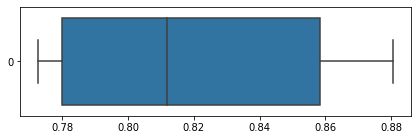

In [107]:
plt.figure(figsize=(7,2))
sns.boxplot(data=scores, orient='h')
plt.show()

### 4.3. Train logistic regression using sklearn

#### Train model

In [108]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### Prediction

In [109]:
y_train_pred = model.predict(X_train)
prob_train_pred = model.predict_proba(X_train)

y_test_pred = model.predict(X_test)
prob_test_pred = model.predict_proba(X_test)

### 4.3. Model Interpretation

#### intercept and coefficients

In [110]:
model.intercept_

array([-0.51356703])

In [111]:
model.coef_

array([[-0.93765934, -0.36914003, -1.75995088, -0.97017625, -0.07121692,
         0.18275863,  0.23733402, -0.41287695,  0.75443547,  0.93891385,
         0.39898386,  2.94824583, -1.06045718,  0.1064367 , -0.14050291,
         0.57970806]])

In [114]:
feature_names = X_train.columns.values
coefficient_list = list(model.coef_[0])
feature_coefficient = [(feature, coefficient) for feature, coefficient in zip(feature_names, coefficient_list)]
feature_coefficient

[('Pclass', -0.9376593379522897),
 ('Sex', -0.3691400262433488),
 ('Age', -1.7599508825652557),
 ('SibSp', -0.9701762503565775),
 ('Parch', -0.07121691940382173),
 ('Fare', 0.18275862928090456),
 ('Embarked', 0.23733401842437735),
 ('Cabin_numerical', -0.41287695286262727),
 ('Cabin_categorical', 0.7544354740236136),
 ('Ticket_numerical', 0.9389138494797722),
 ('Ticket_categorical', 0.398983862004697),
 ('Title', 2.9482458302483776),
 ('Family_size', -1.060457179806875),
 ('is_mother', 0.10643669806217422),
 ('Age_NA', -0.14050290683681252),
 ('Ticket_numerical_NA', 0.5797080611207098)]

In [115]:
#get feature importances from the model
headers = ["name", "score"]
coefficient_list = np.abs(list(model.coef_[0]))
values = sorted(zip(feature_names, coefficient_list), key=lambda x: x[1] * -1)
feature_importances = pd.DataFrame(values, columns = headers)
feature_importances

,name,score
0,Title,2.948246
1,Age,1.759951
2,Family_size,1.060457
3,SibSp,0.970176
4,Ticket_numerical,0.938914
5,Pclass,0.937659
6,Cabin_categorical,0.754435
7,Ticket_numerical_NA,0.579708
8,Cabin_numerical,0.412877
9,Ticket_categorical,0.398984


#### Summary table

In [116]:
def LogisticSummaryTable(classifier, X):
    feature_name = X.columns.values
    summary_table = pd.DataFrame(columns=['feature_name'], data = feature_name)
    summary_table['Coefficient'] = np.transpose(classifier.coef_)
    summary_table.index = summary_table.index + 1
    summary_table.loc[0] = ['Intercept', classifier.intercept_[0]]
    summary_table = summary_table.sort_index()
    summary_table['Odds_ratio'] = np.exp(summary_table.Coefficient)
    summary_table.sort_values('Odds_ratio', ascending = False)

    return summary_table

In [117]:
LogisticSummaryTable(model, X_train)

,feature_name,Coefficient,Odds_ratio
0,Intercept,-0.513567,0.598357
1,Pclass,-0.937659,0.391543
2,Sex,-0.369140,0.691329
3,Age,-1.759951,0.172053
4,SibSp,-0.970176,0.379016
5,Parch,-0.071217,0.931260
6,Fare,0.182759,1.200525
7,Embarked,0.237334,1.267865
8,Cabin_numerical,-0.412877,0.661744
9,Cabin_categorical,0.754435,2.126411


### Creating Summary Table

In [79]:
model.intercept_

array([-0.51356703])

In [80]:
model.coef_

array([[-0.93765934, -0.36914003, -1.75995088, -0.97017625, -0.07121692,
         0.18275863,  0.23733402, -0.41287695,  0.75443547,  0.93891385,
         0.39898386,  2.94824583, -1.06045718,  0.1064367 , -0.14050291,
         0.57970806]])

In [81]:
X_train.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
       'Cabin_numerical', 'Cabin_categorical', 'Ticket_numerical',
       'Ticket_categorical', 'Title', 'Family_size', 'is_mother', 'Age_NA',
       'Ticket_numerical_NA'],
      dtype='object')

In [82]:
summary_table = pd.DataFrame(columns=['FeatureName'], data=X_train.columns)
summary_table['Coefficient'] = np.transpose(model.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercep', model.intercept_[0]]
summary_table = summary_table.sort_index()
summary_table

,FeatureName,Coefficient
0,Intercep,-0.513567
1,Pclass,-0.937659
2,Sex,-0.369140
3,Age,-1.759951
4,SibSp,-0.970176
5,Parch,-0.071217
6,Fare,0.182759
7,Embarked,0.237334
8,Cabin_numerical,-0.412877
9,Cabin_categorical,0.754435


### Interpreting the coefficients

In [83]:
summary_table['Odds_ratio'] = np.exp(summary_table.Coefficient)
summary_table

,FeatureName,Coefficient,Odds_ratio
0,Intercep,-0.513567,0.598357
1,Pclass,-0.937659,0.391543
2,Sex,-0.369140,0.691329
3,Age,-1.759951,0.172053
4,SibSp,-0.970176,0.379016
5,Parch,-0.071217,0.931260
6,Fare,0.182759,1.200525
7,Embarked,0.237334,1.267865
8,Cabin_numerical,-0.412877,0.661744
9,Cabin_categorical,0.754435,2.126411


In [84]:
summary_table.sort_values('Odds_ratio', ascending=True)

,FeatureName,Coefficient,Odds_ratio
3,Age,-1.759951,0.172053
13,Family_size,-1.060457,0.346297
4,SibSp,-0.970176,0.379016
1,Pclass,-0.937659,0.391543
0,Intercep,-0.513567,0.598357
8,Cabin_numerical,-0.412877,0.661744
2,Sex,-0.369140,0.691329
15,Age_NA,-0.140503,0.868921
5,Parch,-0.071217,0.931260
14,is_mother,0.106437,1.112308


### Performance Evaluation

#### Accuracy

In [118]:
accuracy_score(y_train, y_train_pred)

0.8308383233532934

In [119]:
accuracy_score(y_test, y_test_pred)

0.8161434977578476

#### Confusion matrix & Classification Report

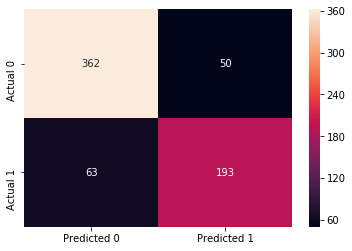

In [120]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, y_train_pred)
cm_df = pd.DataFrame(cm)
cm_df.columns = ['Predicted 0', 'Predicted 1']
cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
sns.heatmap(cm_df, annot=True, fmt="d")
plt.show()

In [121]:
from sklearn.metrics import classification_report
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       412
           1       0.79      0.75      0.77       256

    accuracy                           0.83       668
   macro avg       0.82      0.82      0.82       668
weighted avg       0.83      0.83      0.83       668



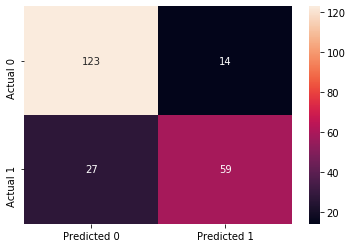

In [122]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred)
cm_df = pd.DataFrame(cm)
cm_df.columns = ['Predicted 0', 'Predicted 1']
cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
sns.heatmap(cm_df, annot=True, fmt="d")
plt.show()

In [123]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       137
           1       0.81      0.69      0.74        86

    accuracy                           0.82       223
   macro avg       0.81      0.79      0.80       223
weighted avg       0.82      0.82      0.81       223



#### ROC AUC Score

In [124]:
roc_auc_score(y_train, prob_train_pred[:,1])

0.8864627578883495

In [125]:
roc_auc_score(y_test, prob_test_pred[:,1])

0.8554150398913597

#### ROC Curve

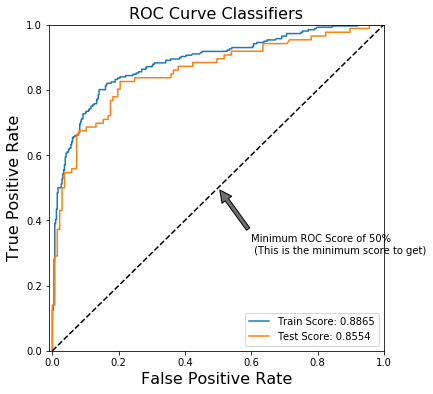

In [126]:
from sklearn.metrics import roc_curve

fpr_train, tpr_train, threshold = roc_curve(y_train, prob_train_pred[:,1])
fpr_test, tpr_test, threshold = roc_curve(y_test, prob_test_pred[:,1])

plt.figure(figsize=(6,6))
plt.title('ROC Curve Classifiers', fontsize=16)
plt.plot(fpr_train, tpr_train, label= 'Train Score: {:.4f}'.format(roc_auc_score(y_train, prob_train_pred[:,1])))
plt.plot(fpr_test, tpr_test, label= 'Test Score: {:.4f}'.format(roc_auc_score(y_test, prob_test_pred[:,1])))

plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05))
plt.legend()
        
plt.show()

#### Precision-Recall curve

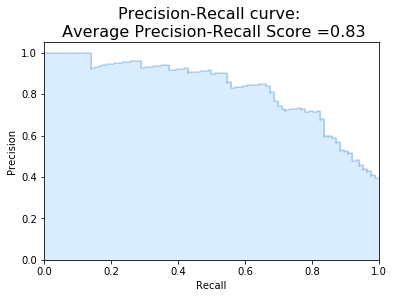

In [127]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_score = prob_test_pred[:,1]
precision, recall, threshold = precision_recall_curve(y_test,y_score)
average_precision = average_precision_score(y_test, y_score)


plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)
plt.show()

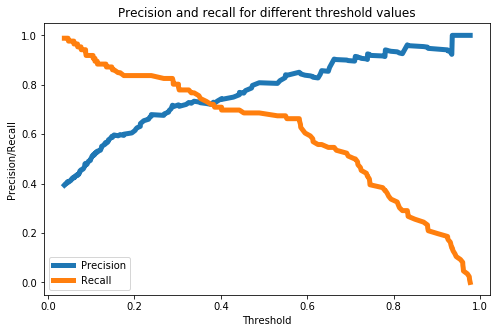

In [128]:
plt.figure(figsize=(8,5))
plt.plot(threshold, precision[1:], label="Precision",linewidth=5)
plt.plot(threshold, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Precision-Recall curve: \n Average Precision-Recall Score =0.86')

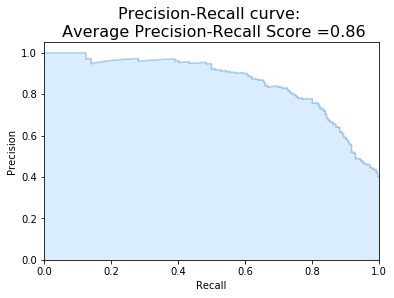

In [129]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_score = prob_train_pred[:,1]
precision, recall, threshold = precision_recall_curve(y_train,y_score)
average_precision = average_precision_score(y_train, y_score)


plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)

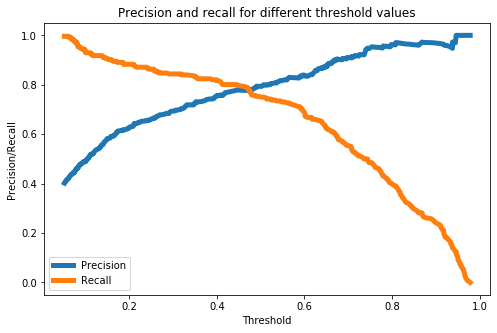

In [130]:
plt.figure(figsize=(8,5))
plt.plot(threshold, precision[1:], label="Precision",linewidth=5)
plt.plot(threshold, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

#### Summary

In [131]:
def ModelEvaluation(model,X_train,y_train,X_test,y_test,name):
    print('Model Evaluation of ' + name)

    print('-----------------------------------------------------------')
    print('Train set')
    print('Accuracy: ', accuracy_score(y_train, y_train_pred))
    print('ROC AUC Score: ', roc_auc_score(y_train, prob_train_pred[:,1]))
    cm_df = pd.DataFrame(confusion_matrix(y_train,y_train_pred), index=model.classes_,columns=model.classes_)
    cm_df.index.name = 'Actual'
    cm_df.columns.name = 'Predicted'
    print('Confusion matrix')
    print(cm_df)
    print(classification_report(y_train, y_train_pred))
    
    print('-----------------------------------------------------------')
    print('Test set')
    print('Accuracy: ', accuracy_score(y_test, y_test_pred))
    print('ROC AUC Score: ', roc_auc_score(y_test, prob_test_pred[:,1]))
    cm_df = pd.DataFrame(confusion_matrix(y_test,y_test_pred), index=model.classes_,columns=model.classes_)
    cm_df.index.name = 'Actual'
    cm_df.columns.name = 'Predicted'
    print('Confusion matrix')
    print(cm_df)
    print(classification_report(y_test, y_test_pred))
    
ModelEvaluation(model,X_train,y_train,X_test,y_test,'Logistic Regression')

Model Evaluation of Logistic Regression
-----------------------------------------------------------
Train set
Accuracy:  0.8308383233532934
ROC AUC Score:  0.8864627578883495
Confusion matrix
Predicted    0    1
Actual             
0          362   50
1           63  193
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       412
           1       0.79      0.75      0.77       256

    accuracy                           0.83       668
   macro avg       0.82      0.82      0.82       668
weighted avg       0.83      0.83      0.83       668

-----------------------------------------------------------
Test set
Accuracy:  0.8161434977578476
ROC AUC Score:  0.8554150398913597
Confusion matrix
Predicted    0   1
Actual            
0          123  14
1           27  59
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       137
           1       0.81      0.69      0.74        86

    accura

### 4.5. Tuning hyper-parameters

#### Apply Grid search and KFold Cross Validation

In [132]:
# Specify parameters
c_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
params = [
    {'C': c_values, 'penalty': ['l1'], 'solver' : ['liblinear'], 'multi_class' : ['ovr']},
    {'C': c_values, 'penalty': ['l2'], 'solver' : ['liblinear', 'newton-cg', 'lbfgs'], 'multi_class' : ['ovr']}
]

grid_search = GridSearchCV(LogisticRegression(), params, cv = 10, verbose = 2)
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 28 candidates, totalling 280 fits
[CV] C=0.001, multi_class=ovr, penalty=l1, solver=liblinear ..........
[CV]  C=0.001, multi_class=ovr, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=0.001, multi_class=ovr, penalty=l1, solver=liblinear ..........
[CV]  C=0.001, multi_class=ovr, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=0.001, multi_class=ovr, penalty=l1, solver=liblinear ..........
[CV]  C=0.001, multi_class=ovr, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=0.001, multi_class=ovr, penalty=l1, solver=liblinear ..........
[CV]  C=0.001, multi_class=ovr, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=0.001, multi_class=ovr, penalty=l1, solver=liblinear ..........
[CV]  C=0.001, multi_class=ovr, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=0.001, multi_class=ovr, penalty=l1, solver=liblinear ..........
[CV]  C=0.001, multi_class=ovr, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=0.001, multi_class=ovr, penalty=l1, solver=libli

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  C=10, multi_class=ovr, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=10, multi_class=ovr, penalty=l1, solver=liblinear .............
[CV]  C=10, multi_class=ovr, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=10, multi_class=ovr, penalty=l1, solver=liblinear .............
[CV]  C=10, multi_class=ovr, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=10, multi_class=ovr, penalty=l1, solver=liblinear .............
[CV]  C=10, multi_class=ovr, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=10, multi_class=ovr, penalty=l1, solver=liblinear .............
[CV]  C=10, multi_class=ovr, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=100, multi_class=ovr, penalty=l1, solver=liblinear ............
[CV]  C=100, multi_class=ovr, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=100, multi_class=ovr, penalty=l1, solver=liblinear ............
[CV]  C=100, multi_class=ovr, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=100, multi_class=ovr, penalty=l1, solver=liblinear ...

[CV]  C=0.01, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=0.01, multi_class=ovr, penalty=l2, solver=newton-cg ...........
[CV]  C=0.01, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=0.01, multi_class=ovr, penalty=l2, solver=newton-cg ...........
[CV]  C=0.01, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=0.01, multi_class=ovr, penalty=l2, solver=newton-cg ...........
[CV]  C=0.01, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=0.01, multi_class=ovr, penalty=l2, solver=newton-cg ...........
[CV]  C=0.01, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=0.01, multi_class=ovr, penalty=l2, solver=newton-cg ...........
[CV]  C=0.01, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=0.01, multi_class=ovr, penalty=l2, solver=newton-cg ...........
[CV]  C=0.01, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=0.01, multi_class=ovr, penalty=l2, solver=

[CV]  C=1, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=1, multi_class=ovr, penalty=l2, solver=newton-cg ..............
[CV]  C=1, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=1, multi_class=ovr, penalty=l2, solver=newton-cg ..............
[CV]  C=1, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=1, multi_class=ovr, penalty=l2, solver=newton-cg ..............
[CV]  C=1, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=1, multi_class=ovr, penalty=l2, solver=newton-cg ..............
[CV]  C=1, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=1, multi_class=ovr, penalty=l2, solver=lbfgs ..................
[CV] ... C=1, multi_class=ovr, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=1, multi_class=ovr, penalty=l2, solver=lbfgs ..................
[CV] ... C=1, multi_class=ovr, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=1, multi_class=ovr, penalty=l2, solver=lbfgs ..................
[

[CV]  C=100, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=100, multi_class=ovr, penalty=l2, solver=newton-cg ............
[CV]  C=100, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=100, multi_class=ovr, penalty=l2, solver=newton-cg ............
[CV]  C=100, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=100, multi_class=ovr, penalty=l2, solver=newton-cg ............
[CV]  C=100, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=100, multi_class=ovr, penalty=l2, solver=newton-cg ............
[CV]  C=100, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=100, multi_class=ovr, penalty=l2, solver=newton-cg ............
[CV]  C=100, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=100, multi_class=ovr, penalty=l2, solver=lbfgs ................
[CV] . C=100, multi_class=ovr, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=100, multi_class=ovr, penalty=l2, solver=lbfgs .....

[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    4.5s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'multi_class': ['ovr'], 'penalty': ['l1'],
                          'solver': ['liblinear']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'multi_class': ['ovr'], 'penalty': ['l2'],
                       

#### Best model

In [133]:
grid_search.best_params_

{'C': 1, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}

In [134]:
best_model = grid_search.best_estimator_
best_model

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

#### Rerun with the best model

In [135]:
scores = cross_val_score(model, X_train, y_train, cv=10)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*scores.mean(), 100*scores.std() * 2))

Accuracy: 82.17% (+/- 7.97%)


In [136]:
scores = cross_val_score(best_model, X_train, y_train, cv=10)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*scores.mean(), 100*scores.std() * 2))

Accuracy: 82.92% (+/- 6.62%)


In [137]:
scores

array([0.86567164, 0.85074627, 0.82089552, 0.80597015, 0.85074627,
       0.86567164, 0.80597015, 0.86567164, 0.77272727, 0.78787879])

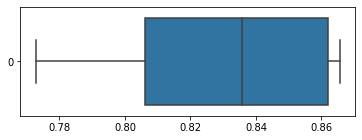

In [138]:
plt.figure(figsize=(6,2))
sns.boxplot(data=scores, orient='h')
plt.show()

In [139]:
best_model.fit(X_train, y_train)
y_train_pred = best_model.predict(X_train)
prob_train_pred = best_model.predict_proba(X_train)

y_test_pred = best_model.predict(X_test)
prob_test_pred = best_model.predict_proba(X_test)

In [140]:
LogisticSummaryTable(best_model, X_train)

,feature_name,Coefficient,Odds_ratio
0,Intercept,0.000000,1.000000
1,Pclass,-1.379802,0.251628
2,Sex,0.000000,1.000000
3,Age,-2.104914,0.121856
4,SibSp,-0.970313,0.378964
5,Parch,0.000000,1.000000
6,Fare,0.000000,1.000000
7,Embarked,0.219659,1.245652
8,Cabin_numerical,-0.498966,0.607158
9,Cabin_categorical,0.629534,1.876736


In [141]:
#get feature importances from the model
headers = ["name", "score"]
coefficient_list = np.abs(list(best_model.coef_[0]))
values = sorted(zip(feature_names, coefficient_list), key=lambda x: x[1] * -1)
feature_importances = pd.DataFrame(values, columns = headers)
feature_importances

,name,score
0,Title,3.515069
1,Age,2.104914
2,Pclass,1.379802
3,Family_size,1.305856
4,SibSp,0.970313
5,Ticket_numerical,0.721760
6,Cabin_categorical,0.629534
7,Cabin_numerical,0.498966
8,Embarked,0.219659
9,Age_NA,0.065549


In [142]:
ModelEvaluation(best_model,X_train,y_train,X_test,y_test,'LogisticRegression')

Model Evaluation of LogisticRegression
-----------------------------------------------------------
Train set
Accuracy:  0.8338323353293413
ROC AUC Score:  0.8856426350121357
Confusion matrix
Predicted    0    1
Actual             
0          362   50
1           61  195
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       412
           1       0.80      0.76      0.78       256

    accuracy                           0.83       668
   macro avg       0.83      0.82      0.82       668
weighted avg       0.83      0.83      0.83       668

-----------------------------------------------------------
Test set
Accuracy:  0.8161434977578476
ROC AUC Score:  0.855839416058394
Confusion matrix
Predicted    0   1
Actual            
0          123  14
1           27  59
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       137
           1       0.81      0.69      0.74        86

    accuracy

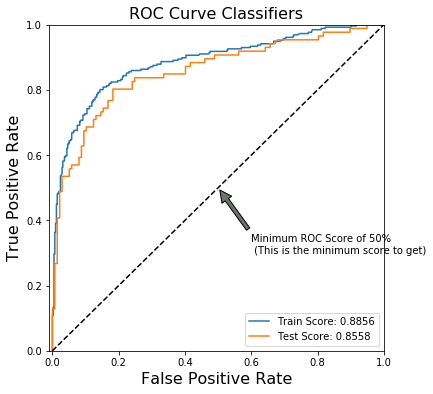

In [143]:
from sklearn.metrics import roc_curve

fpr_train, tpr_train, threshold = roc_curve(y_train, prob_train_pred[:,1])
fpr_test, tpr_test, threshold = roc_curve(y_test, prob_test_pred[:,1])

plt.figure(figsize=(6,6))
plt.title('ROC Curve Classifiers', fontsize=16)
plt.plot(fpr_train, tpr_train, label= 'Train Score: {:.4f}'.format(roc_auc_score(y_train, prob_train_pred[:,1])))
plt.plot(fpr_test, tpr_test, label= 'Test Score: {:.4f}'.format(roc_auc_score(y_test, prob_test_pred[:,1])))

plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05))
plt.legend()
        
plt.show()

In [144]:
y_score = best_model.decision_function(X_test)
precision, recall, threshold = precision_recall_curve(y_test,y_score)
average_precision = average_precision_score(y_test, y_score)

precision_recall_df = pd.DataFrame([precision[0:len(threshold)],recall[0:len(threshold)],threshold]).T
precision_recall_df.columns = ['precision','recall','threshold']
precision_recall_df.head(6)

,precision,recall,threshold
0,0.398148,1.000000,-3.397638
1,0.395349,0.988372,-3.345653
2,0.397196,0.988372,-3.298288
3,0.399061,0.988372,-3.258650
4,0.400943,0.988372,-3.159346
5,0.402844,0.988372,-3.142644


Text(0.5, 1.0, 'Precision-Recall curve: \n Average Precision-Recall Score =0.83')

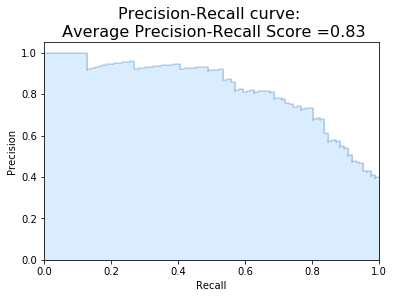

In [145]:
plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)

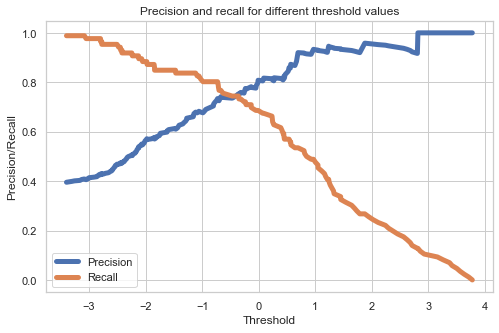

In [146]:
sns.set(style = 'whitegrid',context = 'notebook')
plt.figure(figsize=(8,5))
plt.plot(threshold, precision[1:], label="Precision",linewidth=5)
plt.plot(threshold, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

#### Score

In [85]:
model.score(X_train, y_train)

0.8308383233532934

In [86]:
accuracy_score(y_train, y_train_pred)

0.8308383233532934

In [87]:
accuracy_score(y_test, y_test_pred)

0.8161434977578476

#### Confusion matrix 

#### Classification Report

In [91]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       412
           1       0.79      0.75      0.77       256

    accuracy                           0.83       668
   macro avg       0.82      0.82      0.82       668
weighted avg       0.83      0.83      0.83       668



In [92]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

print('---' * 35)
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_train_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_train_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_train_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_train_pred)))
print('---' * 35)

---------------------------------------------------------------------------------------------------------
Recall Score: 0.75
Precision Score: 0.79
F1 Score: 0.77
Accuracy Score: 0.83
---------------------------------------------------------------------------------------------------------


In [93]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       137
           1       0.81      0.69      0.74        86

    accuracy                           0.82       223
   macro avg       0.81      0.79      0.80       223
weighted avg       0.82      0.82      0.81       223



### ROC Curve

Logistic Regression:  0.8162735133495146


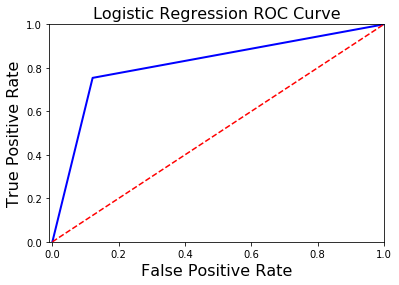

In [94]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, y_train_pred)
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, y_train_pred))

def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(6,4))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
    
    
logistic_roc_curve(log_fpr, log_tpr)
plt.show()

### Precision Recall curve

In [95]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train, y_train_pred)

In [96]:
from sklearn.metrics import average_precision_score

average_precision = average_precision_score(y_test, y_test_pred)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.68


Text(0.5, 1.0, 'UnderSampling Precision-Recall curve: \n Average Precision-Recall Score =0.68')

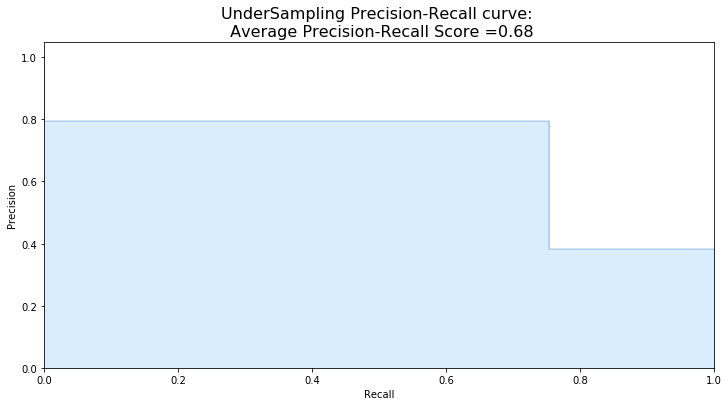

In [97]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(y_train, y_train_pred)

plt.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)

### Model Evaluation

In [98]:
def ModelEvaluation(name,model):
    
        print(name)
        model.fit(X_train[training_vars], y_train)
        
        print('==========================================================')
        print('Train set')
        y_train_pred = model.predict(X_train[training_vars])
        print('Accuracy: ', accuracy_score(y_train, list(y_train_pred)))
        print('ROC AUC Score: ', roc_auc_score(y_train, list(y_train_pred)))
        cm_df = pd.DataFrame(confusion_matrix(y_train,list(y_train_pred)), index=model.classes_,columns=model.classes_)
        cm_df.index.name = 'Predicted'
        cm_df.columns.name = 'True'
        print('Confusion matrix')
        print(cm_df)
        print(classification_report(y_train, list(y_train_pred)))
  
        print('----------------------------------------------------------')
        print('Test set')
        y_test_pred = model.predict(X_test[training_vars])
        print('Accuracy: ', accuracy_score(y_test, list(y_test_pred)))
        print('ROC AUC Score: ', roc_auc_score(y_test, list(y_test_pred)))
        cm_df = pd.DataFrame(confusion_matrix(y_test,list(y_test_pred)), index=model.classes_,columns=model.classes_)
        cm_df.index.name = 'Predicted'
        cm_df.columns.name = 'True'
        print('Confusion matrix')
        print(cm_df)
        print(classification_report(y_test, list(y_test_pred)))
        print('==========================================================')
    
ModelEvaluation('Logistic Regression',model)

Logistic Regression
Train set
Accuracy:  0.8308383233532934
ROC AUC Score:  0.8162735133495146
Confusion matrix
True         0    1
Predicted          
0          362   50
1           63  193
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       412
           1       0.79      0.75      0.77       256

    accuracy                           0.83       668
   macro avg       0.82      0.82      0.82       668
weighted avg       0.83      0.83      0.83       668

----------------------------------------------------------
Test set
Accuracy:  0.8161434977578476
ROC AUC Score:  0.7919283653030045
Confusion matrix
True         0   1
Predicted         
0          123  14
1           27  59
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       137
           1       0.81      0.69      0.74        86

    accuracy                           0.82       223
   macro avg       0.81      0.79    

In [99]:
print('Train score: ', model.score(X_train, y_train))
print('Test score: ', model.score(X_test, y_test))

Train score:  0.8308383233532934
Test score:  0.8161434977578476


In [100]:
y_train_pred = model.predict(X_train[training_vars])
print('Train Accuracy: ', accuracy_score(y_train, list(y_train_pred)))

Train Accuracy:  0.8308383233532934


In [74]:
y_test_pred = model.predict(X_test[training_vars])
print('Test Accuracy: ', accuracy_score(y_test, list(y_test_pred)))

Test Accuracy:  0.8161434977578476


In [67]:
model = LogisticRegression()
model.fit(X_train, y_train)

pred = model.predict_proba(scaler.transform(X_train))
print('Logit train roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
pred = model.predict_proba(scaler.transform(X_test))
print('Logit test roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

Logit train roc-auc: 0.8729805066747572
Logit test roc-auc: 0.8428535053471398


### Select threshold for maximum accuracy

In [68]:
tpr, tpr, thresholds = metrics.roc_curve(y_test, pred[:,1])
thresholds

array([1.99977561, 0.99977561, 0.99761836, 0.99750114, 0.99588481,
       0.99382872, 0.98868351, 0.98766301, 0.97585885, 0.97537531,
       0.97228414, 0.97104241, 0.96813636, 0.96732903, 0.96714427,
       0.96411049, 0.95434452, 0.95106386, 0.9508521 , 0.9460704 ,
       0.93971361, 0.93736297, 0.93679707, 0.92791028, 0.91725218,
       0.91090027, 0.90751562, 0.89018755, 0.88628097, 0.88388265,
       0.86784922, 0.86516247, 0.85765376, 0.84867175, 0.83449191,
       0.82930178, 0.81254761, 0.80272663, 0.79866104, 0.76297332,
       0.7561073 , 0.70937879, 0.67848858, 0.59337192, 0.5143524 ,
       0.48988038, 0.46614578, 0.46550365, 0.4552492 , 0.42229639,
       0.412629  , 0.40904812, 0.40875146, 0.39669353, 0.39557466,
       0.3153883 , 0.31385664, 0.19959692, 0.19814973, 0.1897073 ,
       0.18410068, 0.17473504, 0.16534234, 0.16523064, 0.16476616,
       0.15868203, 0.15854827, 0.09566608, 0.09512515, 0.09506766,
       0.09486665, 0.09480929, 0.09118374, 0.08754125, 0.08336

In [69]:
accuracy_ls = []
for thres in thresholds:
    y_pred = np.where(pred[:,1]>thres,1,0)
    accuracy_ls.append(metrics.accuracy_score(y_test, y_pred, normalize=True))
    
accuracy_ls = pd.concat([pd.Series(thresholds), pd.Series(accuracy_ls)],
                        axis=1)
accuracy_ls.columns = ['thresholds', 'accuracy']
accuracy_ls.sort_values(by='accuracy', ascending=False, inplace=True)
accuracy_ls.head()

,thresholds,accuracy
21,0.937363,0.802691
20,0.939714,0.798206
22,0.936797,0.798206
27,0.890188,0.793722
31,0.865162,0.793722


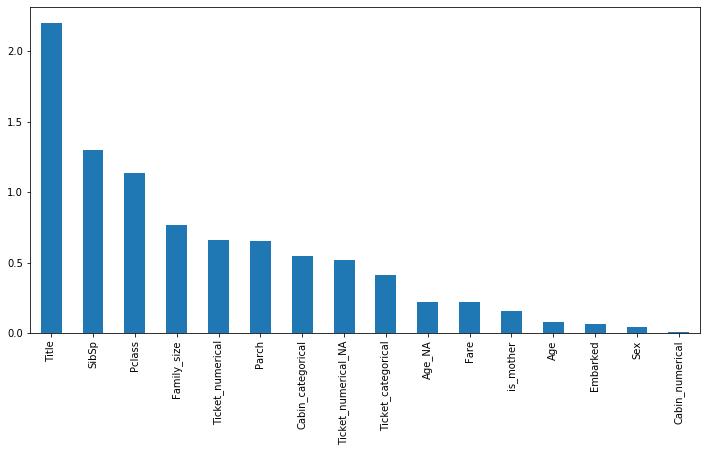

In [70]:
importance = pd.Series(np.abs(logit_model.coef_.ravel()))
importance.index = training_vars
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(12,6))